## Convex Optimization using CVXPY

CVXPY is a Python-embedded language for convex optimization problems. It automatically transforms the problem into standard form, calls a solver, and unpacks the results.

### install:
I used "pip install cvxpy". Otherwise, look at:
https://www.cvxpy.org/install/index.html




The code below solves a simple optimization problem in CVXPY:


In [1]:
import cvxpy as cvx

# Create two scalar optimization variables.
x = cvx.Variable()
y = cvx.Variable()

# Create two constraints.
constraints = [x + y == 1,
               x - y >= 1]

# Form objective.
obj = cvx.Minimize((x - y)**2)

# Form and solve problem.
prob = cvx.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value, y.value)

status: optimal
optimal value 1.0
optimal var 1.0 1.570086213240983e-22


prob.solve() returns the optimal value and updates prob.status, prob.value, and the value field of all the variables in the problem.



Problems are immutable, meaning they cannot be changed after they are created. To change the objective or constraints, create a new problem.



In [2]:
# Replace the objective.
prob2 = cvx.Problem(cvx.Maximize(x + y), prob.constraints)
print("optimal value", prob2.solve())

# Replace the constraint (x + y == 1).
constraints = [x + y <= 3] + prob.constraints[1:]
prob2 = cvx.Problem(prob.objective, constraints)
print("optimal value", prob2.solve())

optimal value 0.9996939016105745
optimal value 1.0


When a problem has no feasible solutions, meaning the set of solutions 
that satisfy the constraints is empty, we say that the 
probelm is "infeasible".


In [3]:
import cvxpy as cvx

x = cvx.Variable()

# An infeasible problem.
prob = cvx.Problem(cvx.Minimize(x), [x >= 1, x <= 0])
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

status: infeasible
optimal value inf


When a problem has no lower bound, meaning the objective function
can achieve arbitrary low values (or negative infinity) we say that the problem is "unbounded".

In [4]:
# An unbounded problem.
prob = cvx.Problem(cvx.Minimize(x))
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

status: unbounded
optimal value -inf


Notice that for a minimization problem the optimal value is inf if infeasible and -inf if unbounded. For maximization problems the opposite is true.



## Vectors and matrices
Variables can be scalars, vectors, or matrices, meaning they are 0, 1, or 2 dimensional.



In [5]:
# A scalar variable.
a = cvx.Variable()

# Vector variable with shape (5,).
x = cvx.Variable(5)

# Matrix variable with shape (5, 1).
x = cvx.Variable((5, 1))

# Matrix variable with shape (4, 7).
A = cvx.Variable((4, 7))

Here’s an example of a CVXPY problem with vectors and matrices:



In [6]:
# Solves a bounded least-squares problem.

import cvxpy as cvx
import numpy

# Problem data.
m = 10
n = 5
numpy.random.seed(1)
A = numpy.random.randn(m, n)
b = numpy.random.randn(m)

# Construct the problem.
x = cvx.Variable(n)
objective = cvx.Minimize(cvx.sum_squares(A*x - b))
constraints = [0 <= x, x <= 1]
prob = cvx.Problem(objective, constraints)

print("Optimal value", prob.solve())
print("Optimal var")
print(x.value) # A numpy ndarray.

Optimal value 4.141338603672535
Optimal var
[-4.95922264e-21  6.07571976e-21  1.34643668e-01  1.24976681e-01
 -4.57130806e-21]


## Constraints
As shown in the example code, you can use ==, <=, and >= to construct constraints in CVXPY. Equality and inequality constraints are elementwise, whether they involve scalars, vectors, or matrices. For example, together the constraints 0 <= x and x <= 1 mean that every entry of x is between 0 and 1.

You cannot construct inequalities with < and >. Strict inequalities don’t make sense in a real world setting. Also, you cannot chain constraints together, e.g., 0 <= x <= 1 or x == y == 2. The Python interpreter treats chained constraints in such a way that CVXPY cannot capture them. CVXPY will raise an exception if you write a chained constraint.

## Parameters

Parameters are symbolic representations of constants. The purpose of parameters is to change the value of a constant in a problem without reconstructing the entire problem.




In [7]:
# Positive scalar parameter.
m = cvx.Parameter(nonneg=True)

# Column vector parameter with unknown sign (by default).
c = cvx.Parameter(5)

# Matrix parameter with negative entries.
G = cvx.Parameter((4, 7), nonpos=True)

# Assigns a constant value to G.
G.value = -numpy.ones((4, 7))

You can initialize a parameter with a value. The following code segments are equivalent:



In [8]:
# Create parameter, then assign value.
rho = cvx.Parameter(nonneg=True)
rho.value = 2

# Initialize parameter with a value.
rho = cvx.Parameter(nonneg=True, value=2)

## Excercise - The lasso regularization path
For $ A\in \mathbb{R}^{m,n}, x\in \mathbb{R}^n, b\in \mathbb{R}^m$,
code and solve the following:

\begin{equation*}
\begin{aligned}
& \underset{X}{\text{minimize}}
& & ||Ax-b||_2^2 + \gamma ||x||_1 \\
& \text{subject to}
& & \gamma \geq 0 \\
\end{aligned}
\end{equation*}


In [9]:
import cvxpy as cvx
import numpy
import matplotlib.pyplot as plt

#generate random input
n = 15
m = 20
numpy.random.seed(1)
A = numpy.random.randn(m, n)
b = numpy.random.randn(m)

# Construct the problem, use cvx.norm(x,1) for ||x||_1
x = cvx.Variable(n)
gamma = cvx.Parameter(nonneg=True)
gamma.value = 0

lasso_obj = cvx.Minimize(cvx.norm(A@x - b, 2)+gamma*cvx.norm(x,1))
lasso_prob = cvx.Problem(lasso_obj)

#call solve() and print output
lasso_prob.solve()  # Returns the optimal value.
print("status:", lasso_prob.status)
print("optimal value", lasso_prob.value)
print("optimal x =", x.value)

status: optimal
optimal value 2.6468679278531
optimal x = [ 0.17492415 -0.38102548  0.3473225   0.0173098  -0.08457829 -0.08134011
  0.29311897  0.27019763  0.17493175 -0.23953444  0.64097929 -0.41633633
  0.12799684  0.10639419 -0.32158408]


The next segment will graph a trade-off curve of $||Ax-B||_2^2$ against $||x||_1$, where x stands for the optimal solution for a given gamma.
We'll draw the curve by solving for different
gamma values, and then take the solver solution's values for 
$||Ax-B||_2^2$ and $||x||_1$.

    Question: Why plot axis is against ||x||_1 and not \gamma*||x||_1 as in the objective?    

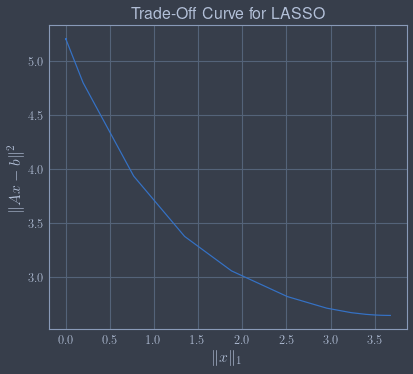

In [28]:
import cvxpy as cvx
import numpy
import matplotlib.pyplot as plt

# matplotlib theme
from jupyterthemes import jtplot
jtplot.style()


# Problem data.
n = 15
m = 20
numpy.random.seed(1)
A = numpy.random.randn(m, n)
b = numpy.random.randn(m)


# Construct the problem as before, 
# but now gamma must be nonnegative parameter.

# We initially built the problem with Gamma as a Parameter so not touching anything here

# Construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
#over the following gamma values
gamma_vals = numpy.logspace(-4, 6)
x_list = []
y_list = []

for g in gamma_vals:
    gamma.value = g
    lasso_prob.solve()
    x_list.append(np.linalg.norm(x.value, 1, axis=0))
    y_list.append(np.linalg.norm(A@x.value - b, 2, axis=0))
    
plt.rc('text', usetex=True)
# Plot trade-off curve
plt.plot(x_list, y_list)
plt.xlabel('$\|x\|_1$', fontsize=16)
plt.ylabel('$\|Ax-b\|^2$', fontsize=16)
plt.title('Trade-Off Curve for LASSO', fontsize=16)
plt.show()

Repeat the previous excercise, but now plot the regularization path: 
    for each gamma, we overlay $(x_i)$, i'th entry of the optimal
    solution x. 

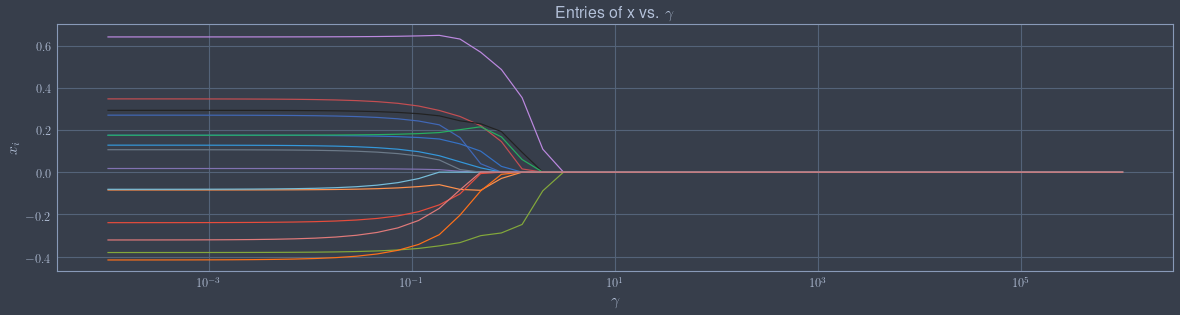

In [30]:
import cvxpy as cvx
import numpy
import matplotlib.pyplot as plt

# Problem data.
n = 15
m = 20
numpy.random.seed(1)
A = numpy.random.randn(m, n)
b = numpy.random.randn(m)

# Construct the problem as before, solve for 
#the following gamma values, and keep the resulting x vectors.
gamma_vals = numpy.logspace(-4, 6)
solutions = []

for g in gamma_vals:
    gamma.value = g
    lasso_prob.solve()
    solutions.append(x.value)

plt.figure(figsize=(20,10))
plt.rc('text', usetex=True)
# Plot entries of x vs. gamma.
plt.subplot(212)
for i in range(n):#replace ... with your optimal solutions list
    plt.plot(gamma_vals, [xi[i] for xi in solutions])
plt.xlabel('$\gamma$', fontsize=16)
plt.ylabel('$x_{i}$', fontsize=16)
plt.xscale('log')
plt.title('Entries of x vs.  $\gamma$', fontsize=16)
plt.show()